In [1]:
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# Reading the csv file and transforming the data using the code from EX1:
df = pd.read_csv('CVD_cleaned.csv')
# Choosing relevant columns:
df = df[['Depression', 'Sex', 'Weight_(kg)', 'Alcohol_Consumption', 
         'Green_Vegetables_Consumption', 'FriedPotato_Consumption' ]]

# Changing categorical variables into binary values
df['Depression'] = df['Depression'].replace(['Yes', 'No'], [1, 0])
df['Sex'] = df['Sex'].replace(['Male', 'Female'], [1, 0])
df

,Depression,Sex,Weight_(kg),Alcohol_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,0,0,32.66,0.0,16.0,12.0
1,0,0,77.11,0.0,0.0,4.0
2,0,0,88.45,4.0,3.0,16.0
3,0,1,93.44,0.0,30.0,8.0
4,0,1,88.45,0.0,4.0,0.0
...,...,...,...,...,...,...
308849,0,1,81.65,4.0,8.0,0.0
308850,0,1,69.85,8.0,60.0,4.0
308851,1,0,61.23,4.0,8.0,4.0
308852,0,1,79.38,3.0,12.0,0.0


# Research question is:
###### Does alcohol consumption vary between men and women?
* X - Alcohol_Consumption
* Y - Sex (2 categories: 1 - male, 0 - female)

## Question 1 - estimation

### 1.1 - Calculating mean of every category

In [3]:
print(df.groupby('Sex')['Alcohol_Consumption'].mean())

Sex
0    4.075102
1    6.196895
Name: Alcohol_Consumption, dtype: float64


### 1.2 - Calculating expectation of X and confidence interval
* We can assume that our MLE is normally distributed due to the Central Limit Theorem. 
    Our data is big enough so we can use the theorem.

In [4]:
def confidence_interval(df):
    """
    This function calculates confidence interval for the expectation of alcohol consumption among male and female.
    """
    # Separate the data for each sex
    alcohol_female = df[df['Sex'] == 0]['Alcohol_Consumption']
    alcohol_male = df[df['Sex'] == 1]['Alcohol_Consumption']
    
    var_female = alcohol_female.var()
    var_male = alcohol_male.var()
    se_female = np.sqrt(var_female / len(alcohol_female))
    se_male = np.sqrt(var_male / len(alcohol_male))

    # MLE:
    expectation_female = alcohol_female.mean()
    expectation_male = alcohol_male.mean()
    
    # CI
    low_bound_male = expectation_male - (1.96 * se_male)
    high_bound_male = expectation_male + (1.96 * se_male)
    low_bound_female = expectation_female - (1.96 * se_female)
    high_bound_female = expectation_female + (1.96 * se_female)
    return low_bound_male, high_bound_male, low_bound_female, high_bound_female
    

res = confidence_interval(df)
print(f"Confidence interval for male is: [{res[0]}, {res[1]}]")
print(f"Confidence interval for female is: [{res[2]}, {res[3]}]")


Confidence interval for male is: [6.151286591532894, 6.242503180965055]
Confidence interval for female is: [4.039529643622619, 4.110673857089009]


### 1.3 
#### **As we can notice that the confidence intervals do not overlap, it might suggests that there is a statistically significant difference between the average alcohol consumption of males and females.**

## Question 2 

### 2.1:
##### H0 is: mu_x - mu_y = 0
##### H1 is : mu_x - mu_y != 0

* mu_x is mean among male
* mu_y is mean among female 

### 2.2:


In [5]:
alcohol_female = df[df['Sex'] == 0]['Alcohol_Consumption']
alcohol_male = df[df['Sex'] == 1]['Alcohol_Consumption']

var_female = alcohol_female.var(ddof=1)
var_male = alcohol_male.var(ddof=1) 

F = stats.f.ppf(0.95, len(alcohol_male) - 1, len(alcohol_female) - 1)
F_test = var_male / var_female # male variance is bigger then female.
print(f"F_test is {F_test > F}")


F_test is True


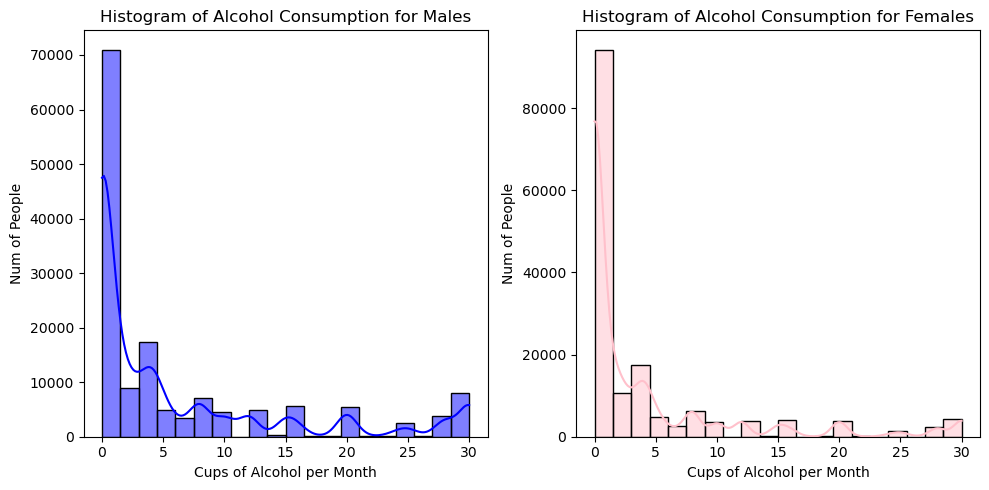

In [6]:
# Separate data for males and females
alcohol_male1 = df[df['Sex'] == 1]['Alcohol_Consumption']
alcohol_female1 = df[df['Sex'] == 0]['Alcohol_Consumption']

# Plot histograms
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(alcohol_male1, bins=20, kde=True, color='blue')
plt.xlabel("Cups of Alcohol per Month")
plt.ylabel("Num of People")
plt.title('Histogram of Alcohol Consumption for Males')

plt.subplot(1, 2, 2)
sns.histplot(alcohol_female1, bins=20, kde=True, color='pink')
plt.title('Histogram of Alcohol Consumption for Females')
plt.xlabel("Cups of Alcohol per Month")
plt.ylabel("Num of People")
plt.tight_layout()
plt.show()

* t test assumptions do not met, since the variance of our 2 groups is not equal
* It can be clearly seen that the data is not normally distributed


### 2.3: t test


In [7]:
t = stats.t.ppf(0.95, len(alcohol_male) + len(alcohol_female) - 2)

# Performing a two-sample t-test assuming equal variances
t_test, p_value = stats.ttest_ind(alcohol_male, alcohol_female, equal_var=True)
print(f"t_test: {t_test > t or t_test < -t}")
print(f"p_value is {p_value}")

t_test: True
p_value is 0.0


### 2.4: Wald test
* H0: delta = 0
* H1: delta != 0
* T.S.: T = mean_x - mean_y / sqrt(var(x)^2 / len(x) + var(y)^2 / len(y))
* R.R.: |T| > 1.96 (for alpha = 0.05)

In [8]:
def wald_test_func(df_1, df_2): # df_1 is alcohol_male, df_2 is alcohol_female.
    """
    This function calculates wald test for the expectation of alcohol consumption among male and female.
    """
    
    # Calculate mean and variance for each group
    mean_male = df_1.mean()
    mean_female = df_2.mean()
    var_female = df_2.var(ddof=1)
    var_male = df_1.var(ddof=1) 

    # Calculate the Wald test statistic
    wald_test = (mean_male - mean_female) / (((var_male ) / len(df_1)) + ((var_female) / len(df_2)) **0.5)
                                            
                
    # Calculate the two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(wald_test)))
    return wald_test, p_value

wald_test, p_value = wald_test_func(alcohol_male, alcohol_female)
print(f"wald_test: {wald_test > 1.96 or wald_test < -1.96}")
print("p-value:", p_value)

wald_test: True
p-value: 0.0


### 2.5: 
#### As we can see by t test and wald test we can reject H0, it means that there is strong evidence to suggest that there is a significant difference between the average alcohol consumption of males and females.
#### p_value on both tests is very small,  that leads to  rejection of the H0 in favor of H1.

### 2.6: 
By the likelihood ratio test we need to reject H0:

In [9]:
male_len = len(alcohol_male)
female_len = len(alcohol_female)
n = male_len + female_len
var_tot = df['Alcohol_Consumption'].var()
mean_tot = df['Alcohol_Consumption'].mean()
var_male = alcohol_male.var(ddof=0)
var_female = alcohol_female.var()
sp_squared = ((male_len - 1) * var_male + (female_len - 1) * var_female) / (male_len + female_len - 2) 

# Computing likelihoods under null and alternative hypotheses
l_male =  stats.norm.pdf(alcohol_male, alcohol_male.mean(), sp_squared ** 0.5)
l_female =  stats.norm.pdf(alcohol_female, alcohol_female.mean(), sp_squared ** 0.5)
l_h0 = stats.norm.pdf(df['Alcohol_Consumption'], mean_tot, var_tot **0.5)

# Calculating likelihood ratio statistic
likelihood_ratio = 2 * (np.sum(np.log(l_male)) + np.sum(np.log(l_female)) - np.sum(np.log(l_h0)))

chi = stats.chi2.ppf(0.95, 1)

print(likelihood_ratio > chi)

True


## Question 3

### 3.1: 


In [10]:
sample_30 = pd.DataFrame(df[['Alcohol_Consumption', 'Sex']].sample(30))
sample_50 = pd.DataFrame(df[['Alcohol_Consumption', 'Sex']].sample(50))
sample_100 = pd.DataFrame(df[['Alcohol_Consumption', 'Sex']].sample(100))
sample_500 = pd.DataFrame(df[['Alcohol_Consumption', 'Sex']].sample(500))


### 3.2: 


In [11]:
samples = [sample_30, sample_50, sample_100, sample_500]
idx = [30, 50, 100, 500]

for i, sample in zip(idx, samples):
    res = confidence_interval(sample)
    print(f"Sample {i}:")
    print(f"Confidence interval for male is: [{res[0]}, {res[1]}]")
    print(f"Confidence interval for female is: [{res[2]}, {res[3]}]\n")


Sample 30:
Confidence interval for male is: [3.2119952544669337, 15.095697053225372]
Confidence interval for female is: [1.6224536856154734, 7.083428667325702]

Sample 50:
Confidence interval for male is: [1.5430628363562664, 5.540270496977067]
Confidence interval for female is: [1.8480429120202282, 6.613495549518234]

Sample 100:
Confidence interval for male is: [4.806711440544266, 10.526621892789068]
Confidence interval for female is: [2.1878583105937026, 4.95499883226344]

Sample 500:
Confidence interval for male is: [5.611093108990943, 7.918318655714939]
Confidence interval for female is: [3.177490323215434, 5.0592443706621175]



* We can notice that CI of male and female gets smaller as sample size gets bigger. 
* Also, there is an overlap between the CI'S, unlike question 1. 
* CI in question 1 is the is the narrowest, since it has the biggest sample size.

### 3.3:

In [12]:
for i, sample in zip(idx, samples):
    male = sample[sample['Sex'] == 1]['Alcohol_Consumption']
    female = sample[sample['Sex'] == 0]['Alcohol_Consumption']
    wald_statistic, p_value = wald_test_func(male, female) 
    print(f"Sample {i}:")
    print(f"Wald test statistic: {wald_statistic > 1.96 or wald_statistic < -1.96}")
    print(f"p-value: {p_value}\n")



Sample 30:
Wald test statistic: False
p-value: 0.6500993362547587

Sample 50:
Wald test statistic: False
p-value: 0.7599648862042803

Sample 100:
Wald test statistic: False
p-value: 0.14859805413238414

Sample 500:
Wald test statistic: True
p-value: 0.0013647524272277778



* It can be seen that the p_value is getting smaller as the sample size is getting bigger.
* p_value from question 1 is smaller than the p_value of the sample of 500.

### 3.4:

In [21]:
interval_30_male = []
interval_50_male = []
interval_100_male = []
interval_500_male = []
interval_30_female = []
interval_50_female = []
interval_100_female = []
interval_500_female = []
p_value_30 = []
p_value_50 = []
p_value_100 = []
p_value_500 = []
count_30_male = 0
count_50_male = 0
count_100_male = 0
count_500_male = 0
count_30_female = 0
count_50_female = 0
count_100_female = 0
count_500_female = 0
ci_30_male = []
ci_50_male = []
ci_100_male = []
ci_500_male = []
ci_30_female = []
ci_50_female = []
ci_100_female = []
ci_500_female = []
female_mean = df.groupby('Sex')['Alcohol_Consumption'].mean()[0]
male_mean = df.groupby('Sex')['Alcohol_Consumption'].mean()[1]                                                        
for i in range(100):
    # Splitting the data
    sample_30 = pd.DataFrame(df[['Alcohol_Consumption', 'Sex']].sample(30))
    sample_50 = pd.DataFrame(df[['Alcohol_Consumption', 'Sex']].sample(50))
    sample_100 = pd.DataFrame(df[['Alcohol_Consumption', 'Sex']].sample(100))
    sample_500 = pd.DataFrame(df[['Alcohol_Consumption', 'Sex']].sample(500))
    
    male_30 = sample_30[sample_30['Sex'] == 1]['Alcohol_Consumption']
    female_30 = sample_30[sample_30['Sex'] == 0]['Alcohol_Consumption']
    male_50 = sample_50[sample_50['Sex'] == 1]['Alcohol_Consumption']
    female_50 = sample_50[sample_50['Sex'] == 0]['Alcohol_Consumption']
    male_100 = sample_100[sample_100['Sex'] == 1]['Alcohol_Consumption']
    female_100 = sample_100[sample_100['Sex'] == 0]['Alcohol_Consumption']
    male_500 = sample_500[sample_500['Sex'] == 1]['Alcohol_Consumption']
    female_500 = sample_500[sample_500['Sex'] == 0]['Alcohol_Consumption']
    
    # Calculating confidence intervals:
    ci_30_male.append([confidence_interval(sample_30)[0], confidence_interval(sample_30)[1]])
    ci_50_male.append([(confidence_interval(sample_50)[0], confidence_interval(sample_50)[1])])
    ci_100_male.append([confidence_interval(sample_100)[0], confidence_interval(sample_100)[1]])
    ci_500_male.append([confidence_interval(sample_500)[0], confidence_interval(sample_500)[1]])
    
    ci_30_female.append([confidence_interval(sample_30)[2], confidence_interval(sample_30)[3]])
    ci_50_female.append([confidence_interval(sample_50)[2], confidence_interval(sample_50)[3]]) 
    ci_100_female.append([confidence_interval(sample_100)[2], confidence_interval(sample_100)[3]])
    ci_500_female.append([confidence_interval(sample_500)[2] , confidence_interval(sample_500)[3]])
    
    # Calculating the length of confidence interval:
    interval_30_male.append(confidence_interval(sample_30)[1] - confidence_interval(sample_30)[0])
    interval_50_male.append(confidence_interval(sample_50)[1] - confidence_interval(sample_50)[0]) 
    interval_100_male.append(confidence_interval(sample_100)[1] - confidence_interval(sample_100)[0])
    interval_500_male.append(confidence_interval(sample_500)[1] - confidence_interval(sample_500)[0])
    interval_30_female.append(confidence_interval(sample_30)[3] - confidence_interval(sample_30)[2])
    interval_50_female.append(confidence_interval(sample_50)[3] - confidence_interval(sample_50)[2]) 
    interval_100_female.append(confidence_interval(sample_100)[3] - confidence_interval(sample_100)[2])
    interval_500_female.append(confidence_interval(sample_500)[3] - confidence_interval(sample_500)[2])
    
    # P value:
    p_value_30.append(wald_test_func(male_30, female_30)[1])
    p_value_50.append(wald_test_func(male_50, female_50)[1])
    p_value_100.append(wald_test_func(male_100, female_100)[1])
    p_value_500.append(wald_test_func(male_500, female_500)[1])
    
    # Counting number of times the mean is in the confidence interval:
    if confidence_interval(sample_30)[2] <= female_mean <= confidence_interval(sample_30)[3]:
        count_30_female += 1
    if confidence_interval(sample_50)[2] <= female_mean <= confidence_interval(sample_50)[3]:
        count_50_female += 1
    if confidence_interval(sample_100)[2] <= female_mean <= confidence_interval(sample_100)[3]:
        count_100_female += 1
    if confidence_interval(sample_500)[2] <= female_mean <= confidence_interval(sample_500)[3]:
        count_500_female += 1
    
    if confidence_interval(sample_30)[0] <= male_mean <= confidence_interval(sample_30)[1]:
        count_30_male += 1
    if confidence_interval(sample_50)[0] <= male_mean <= confidence_interval(sample_50)[1]:
        count_50_male += 1
    if confidence_interval(sample_100)[0] <= male_mean <= confidence_interval(sample_100)[1]:
        count_100_male += 1
    if confidence_interval(sample_500)[0] <= male_mean <= confidence_interval(sample_500)[1]:
        count_500_male += 1

In [22]:
print("Male: ")
print(f"The percentage of times the male mean appears in the confidence interval for sample of 30: {count_30_male}%")
print(f"The percentage of times the male mean appears in the confidence interval for sample of 50: {count_50_male}%")
print(f"The percentage of times the male mean appears in the confidence interval for sample of 100: {count_100_male}%")
print(f"The percentage of times the male mean appears in the confidence interval for sample of 500: {count_500_male}%\n")

Male: 
The percentage of times the male mean appears in the confidence interval for sample of 30: 87%
The percentage of times the male mean appears in the confidence interval for sample of 50: 94%
The percentage of times the male mean appears in the confidence interval for sample of 100: 92%
The percentage of times the male mean appears in the confidence interval for sample of 500: 94%



In [23]:
print("Female: ")
print(f"The percentage of times the female mean appears in the confidence interval for sample of 30: {count_30_female}%")
print(f"The percentage of times the female mean appears in the confidence interval for sample of 50: {count_50_female}%")
print(f"The percentage of times the female mean appears in the confidence interval for sample of 100: {count_100_female}%")
print(f"The percentage of times the female mean appears in the confidence interval for sample of 500: {count_500_female}%\n")

Female: 
The percentage of times the female mean appears in the confidence interval for sample of 30: 89%
The percentage of times the female mean appears in the confidence interval for sample of 50: 89%
The percentage of times the female mean appears in the confidence interval for sample of 100: 92%
The percentage of times the female mean appears in the confidence interval for sample of 500: 96%



* we can notice that as sample size gets bigger it is more likely that our estimator of mean is in the CI.

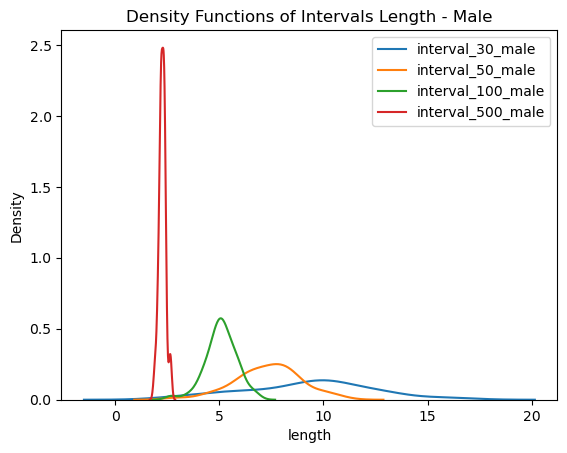

In [53]:
# List of  intervals
intervals1 = [interval_30_male, interval_50_male, interval_100_male, interval_500_male]
indices = [30, 50, 100, 500]
# Plotting each density function
for i, interval in zip(indices, intervals1):
    sns.kdeplot(interval, shade=False, label=f'interval_{i}_male')
    
plt.title('Density Functions of Intervals Length - Male')
plt.xlabel('length')
plt.ylabel('Density')
plt.legend()
plt.show()


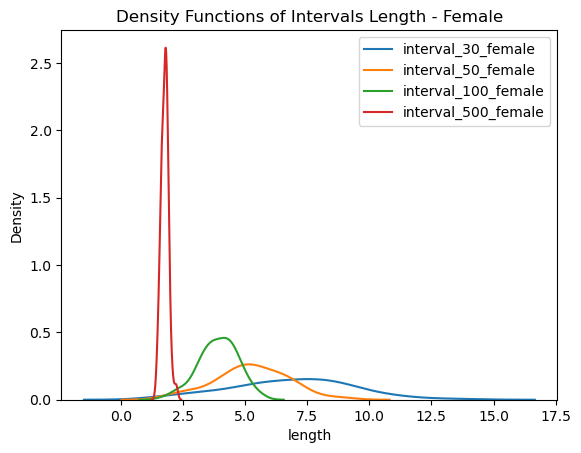

In [54]:
intervals2 = [interval_30_female, interval_50_female, interval_100_female, interval_500_female]
indices = [30, 50, 100, 500]
# Plotting each density function
for i, interval in zip(indices, intervals2):
    sns.kdeplot(interval, shade=False, label=f'interval_{i}_female')
    
plt.title('Density Functions of Intervals Length - Female')
plt.xlabel('length')
plt.ylabel('Density')
plt.legend()
plt.show()

* From both male and female plots of CI length we can see that as the sample size gets bigger the length gets smaller.

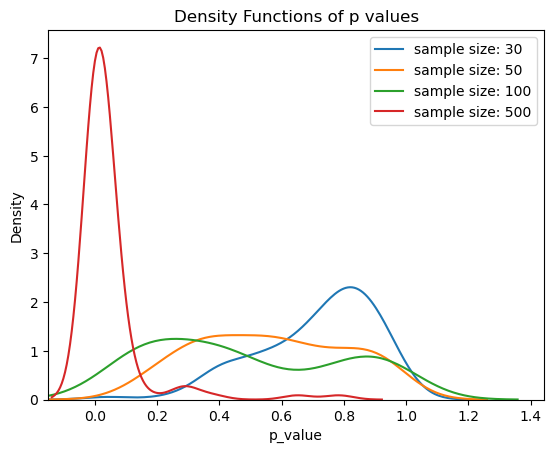

In [64]:
# List of p_value lists
p_values = [p_value_30, p_value_50, p_value_100, p_value_500]
indices = [30, 50, 100, 500]
# Plotting each density function
for i, p_value_list in zip(indices, p_values):
    sns.kdeplot(p_value_list, shade=False, label=f'sample size: {i}')
    
plt.title('Density Functions of p values')
plt.xlabel('p_value')
plt.ylabel('Density')
plt.xlim(left=-0.15)
plt.legend()
plt.show()

* We can learn from this plot that when sample size is 500, p values are very close to zero, means that we reject H0.